In [430]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.base import BaseEstimator
import gensim 
from nltk.corpus import stopwords
from scipy import stats
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OrdinalEncoder
import lightgbm as lgb
from nltk.tokenize import word_tokenize
from imblearn.over_sampling import SMOTE
import re
from nltk.corpus import stopwords
from gensim import corpora
from sklearn.svm import SVC
stop_words = stopwords.words("english")
plt.style.use('seaborn-whitegrid')

This data originally came from Crowdflower's [Data for Everyone library](http://www.crowdflower.com/data-for-everyone).

As the original source says,

> We looked through tens of thousands of tweets about the early August GOP debate in Ohio and asked contributors to do both sentiment analysis and data categorization. Contributors were asked which candidate was mentioned, and what the sentiment was for a given tweet. 

In [431]:
# load dataset 
tweets = pd.read_csv('input/Sentiment.csv', parse_dates=['tweet_created'])
tweets.sample(5)

,Unnamed: 0,id,candidate,sentiment,name,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
9156,9156,9157,No candidate mentioned,Negative,new_debis,0,"""@RWSurferGirl: We the American people pick th...",NaN,2015-08-06 20:52:45-07:00,629500400433893376,NaN,NaN
2579,2579,2580,Jeb Bush,Neutral,DeafFromAIDS,8,"RT @NicholasPell: ""Whatever the geometric mean...",NaN,2015-08-07 09:29:13-07:00,629690770799374336,Milton Keynes,NaN
5055,5055,5056,No candidate mentioned,Negative,NOtoGMOs,39,RT @2noame: So @SenSanders live-tweeted the #G...,NaN,2015-08-07 08:41:09-07:00,629678674418225152,Montreal,Eastern Time (US & Canada)
11121,11121,11122,Scott Walker,Negative,jsc1835,0,"Scott Walker, what about YOUR email controvers...",NaN,2015-08-06 19:42:57-07:00,629482833212391425,NaN,Central Time (US & Canada)
1919,1919,1920,Chris Christie,Negative,xbgix,0,@seanhannity @ChrisChristie @GovChristie Then ...,NaN,2015-08-07 09:36:13-07:00,629692531714887681,Seattle,Pacific Time (US & Canada)


In [432]:
print(f"dataset contains {tweets.shape[0]} tweets and {tweets.shape[1]} predictor variables.")

dataset contains 13871 tweets and 12 predictor variables.


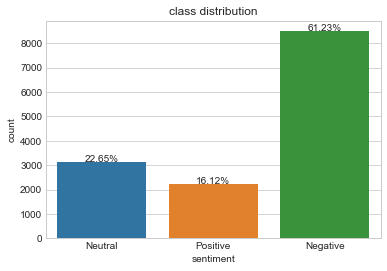

In [433]:
plt.figure()
ax = plt.axes()
sns.countplot(tweets.sentiment)

total_tweets = len(tweets)
plt.title('class distribution')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+20,
            f'{int(height)/total_tweets:.2%}',
            ha="center", fontsize=10)
    
plt.show()

In [434]:
contingency_table = pd.crosstab(tweets.candidate, tweets.sentiment)
contingency_table['negative_proportion'] = contingency_table.Negative/contingency_table.sum(axis=1)
contingency_table

sentiment,Negative,Neutral,Positive,negative_proportion
candidate,,,,
Ben Carson,186,54,164,0.460396
Chris Christie,218,42,33,0.744027
Donald Trump,1758,446,609,0.624956
Jeb Bush,589,72,44,0.835461
John Kasich,82,47,113,0.338843
Marco Rubio,105,51,119,0.381818
Mike Huckabee,237,83,73,0.603053
No candidate mentioned,4724,2087,680,0.630623
Rand Paul,148,60,55,0.562738


The candidate `Donald Trump` has the highest number of negative tweets. However, if we look at the total number of tweet per candidate we can see that `Jeb Bush` has almost 84% of the tweets mentioning him as negative.

**What kind of tweets are the most retweeted?**

In [435]:
tweets.groupby('sentiment').sum()['retweet_count']

sentiment
Negative    419335.0
Neutral     117243.0
Positive     98760.0
Name: retweet_count, dtype: float64

Negative tweets are more than 4 times retweeted than positive tweets. 

**Who are the most retweeted candidates?**

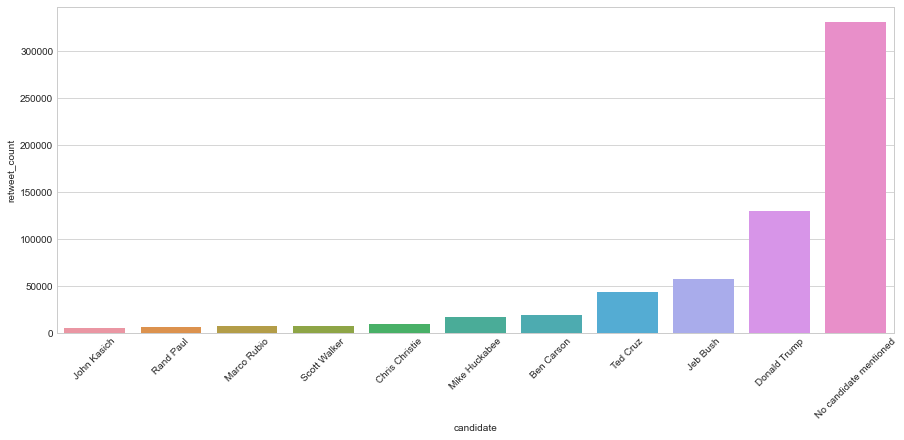

In [436]:
most_rt_candidates = tweets.groupby('candidate').sum()['retweet_count'].sort_values()
plt.figure(figsize=(15,6))
sns.barplot(most_rt_candidates.index, most_rt_candidates)
plt.xticks(rotation=45)
plt.show()

Let us have a look at the time variable `tweet_created`

In [437]:
start_date = tweets.tweet_created.sort_values().iloc[0]
end_date = tweets.tweet_created.sort_values().iloc[-1]
start_date, end_date, (end_date - start_date), start_date.day_name(), end_date.day_name()

(Timestamp('2015-08-06 17:44:53-0700', tz='pytz.FixedOffset(-420)'),
 Timestamp('2015-08-07 10:12:32-0700', tz='pytz.FixedOffset(-420)'),
 Timedelta('0 days 16:27:39'),
 'Thursday',
 'Friday')

We can conclude that the tweets recording lasted for 16hours and ~28 minute. The recodring started Thursday, august 2015 at 17:44 until friday, august 2015 at 10:12.

**How are tweets distributed accros the day? is there any time slot that has more tweets than others?**

In [438]:
tweets_ordered_bytime = tweets.sort_values(by='tweet_created')

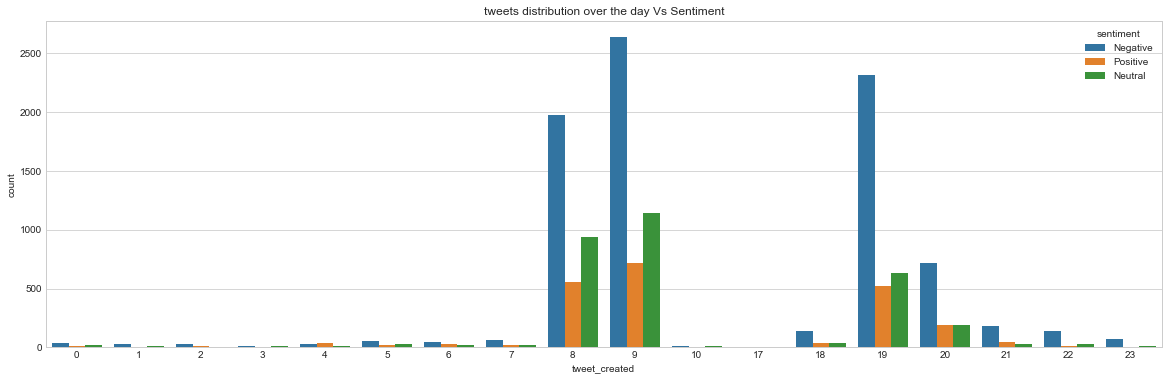

In [439]:
plt.figure(figsize=(20,6))
sns.countplot(tweets_ordered_bytime.tweet_created.dt.hour, hue=tweets_ordered_bytime.sentiment)
plt.title('tweets distribution over the day Vs Sentiment')
plt.show()

We might one to add a new predictor variable that stores the hour of the day or maybe categorigal variable with the following enumeration: morning, afternoon, evening, night

## Missing values

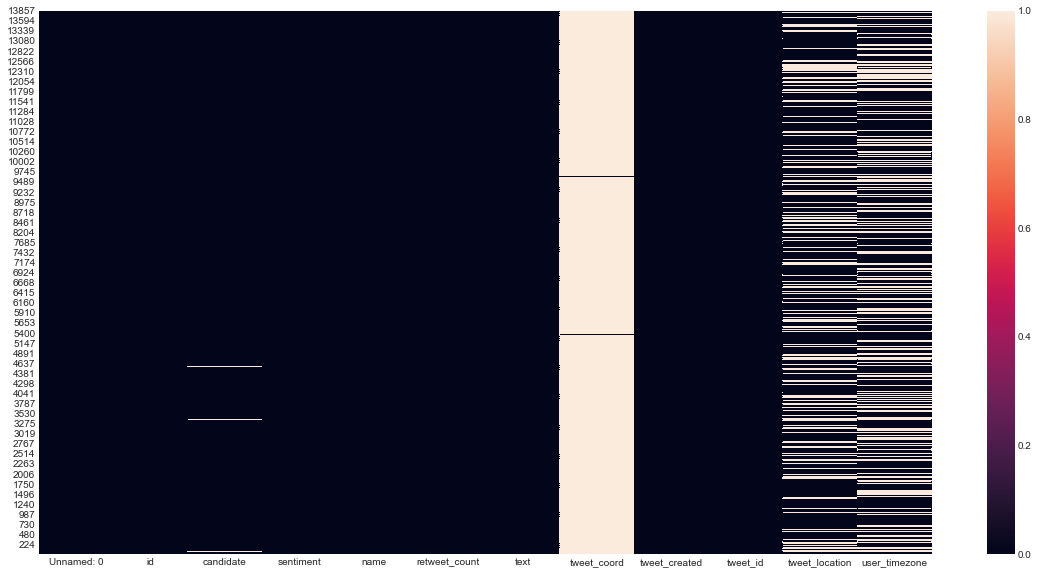

In [440]:
plt.figure(figsize=(20,10))
sns.heatmap(tweets_ordered_bytime.isna())
plt.show()

`Tweet_location` and `user_timezone` contain a lot of missing values.
- add new boolean is_nan + impuatation most freq ?

As to `tweet_coord` we will simply drop it.

In [441]:
tweets.drop(columns=['tweet_coord'], inplace=True)

In [442]:
tweets.tweet_location.isna().sum()/len(tweets), tweets.user_timezone.isna().sum()/len(tweets)

(0.28202725109941607, 0.3174248431980391)

Tweet_location and user_timezone are composed of neary 30% of missing of values.

In [443]:
def is_feature_important(feature, target, alpha=.05):
    crosstable = pd.crosstab(target,feature) 
    chi2, p, dof, expected = stats.chi2_contingency(crosstable.values)
    
    return p < alpha

In [444]:
is_feature_important(tweets.user_timezone, tweets.sentiment), is_feature_important(tweets.tweet_location, tweets.sentiment)

(True, True)

- Tweet_location and user_timezone are correlated with the target variable accorind to kh2 test of independance.

## Tweet's text

Let's print some tweets and see how they look

In [445]:
tweets.text.sample(2).to_list()

['Fox seems to be doing a hit job for GOP on @realDonaldTrump #gopdebates',
 "RT @FredZeppelin12: WINNER OF TONIGHT's TWO DEBATES:\n\n@CarlyFiorina  \n\n#GOPDebate"]

Before analyzing tweets some cleaning has to be performed:
- remove special caracters.
- remove links


In [447]:
def pre_process_tweets(tweet):
    tweet = re.sub(r'http[s]*\S+', '', tweet)
    tweet = re.sub('[#@RT]+\S+', '', tweet)
    tweet = re.sub('&amp;', '', tweet)
    tweet = re.sub(r'http[s]*\S+', '', tweet)
    #replace('\s+', ' ').str.strip()
    tokens = word_tokenize(tweet)
    
    tokens = [token for token in tokens if token.isalpha()]
    tokens = [token.lower() for token in tokens]
    # no lemmatization or stemming since we are going to use pre-trained embeddings
    
    
    # delete stop words
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

tweets['tokens'] = tweets.text.apply(pre_process_tweets)

## Topic modeling

In [455]:
# Create dictionary
dictionary = corpora.Dictionary(tweets.tokens)
print(dictionary)

Dictionary(9462 unique tokens: ['change', 'climate', 'everyone', 'exactly', 'feel']...)


In [458]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.matutils import Sparse2Corpus
from gensim.models import LdaModel
from pprint import pprint

# Instantiate the TF-IDF vectorizer
vectorizer = TfidfVectorizer(lowercase=False, analyzer=lambda x: x)

# Compute the TF-IDF
tf_idf = vectorizer.fit_transform(tweets['tokens'])

# Convert the TF-IDF to the needed input for Gensim
tf_idf_sklearn = Sparse2Corpus(tf_idf, documents_columns=False)

# Compute the LDA
lda2 = LdaModel(corpus=tf_idf_sklearn, id2word=dictionary, num_topics=3, passes=10)

# Print the main topics
pprint(lda2.print_topics())

[(0,
  '0.010*"disturbing" + 0.009*"new" + 0.009*"collective" + 0.009*"quality" + '
  '0.008*"command" + 0.008*"hungry" + 0.008*"lanes" + 0.007*"holden" + '
  '0.007*"eds" + 0.007*"handed"'),
 (1,
  '0.013*"replaced" + 0.012*"counties" + 0.011*"handed" + 0.011*"disturbing" + '
  '0.009*"kutcher" + 0.008*"snapping" + 0.007*"crossing" + 0.007*"wars" + '
  '0.007*"asian" + 0.007*"honestly"'),
 (2,
  '0.017*"involves" + 0.017*"personally" + 0.012*"ad" + 0.011*"disturbing" + '
  '0.011*"knew" + 0.011*"dump" + 0.009*"andrea" + 0.009*"earful" + '
  '0.009*"buzzer" + 0.009*"horse"')]


In [459]:
# Import the modules
import pyLDAvis
import pyLDAvis.gensim

bow = [dictionary.doc2bow(token) for token in tweets.tokens]

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(topic_model=lda2, corpus=bow, dictionary=dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.096223  0.162197       1        1  44.618526
1     -0.128686 -0.147305       2        1  28.915077
2      0.224909 -0.014891       3        1  26.466400, topic_info=            Term        Freq       Total Category  logprob  loglift
4551    involves  420.000000  420.000000  Default  30.0000  30.0000
1150  personally  416.000000  416.000000  Default  29.0000  29.0000
4140    replaced  342.000000  342.000000  Default  28.0000  28.0000
9093          ad  300.000000  300.000000  Default  27.0000  27.0000
1450        knew  279.000000  279.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
468       simply  208.690506  289.175995   Topic3  -4.7679   1.0031
4592    football  173.864731  212.788681   Topic3  -4.9505   1.1273
3419  disturbing  277.852570  981.081665   Topic3  -4.4817   0.0677
6714  greivenses  174.031372  269.700958   Topic3  -4.9495   0.8912
5615      plants  169.707581  289.970032   Topic3  -4.9747   0.7936

[161 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
783       1  0.792652   active
783       2  0.006193   active
783       3  0.204355   active
9093      1  0.003333       ad
9093      2  0.003333       ad
...     ...       ...      ...
596       2  0.008566     word
596       3  0.008566     word
8819      1  0.991855  wrapped
8819      2  0.005276  wrapped
8819      3  0.005276  wrapped

[372 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

In [468]:
tweets_complexity = pd.DataFrame()
tweets_complexity['tweet_len'] = tweets.text.str.len()
tweets_complexity['num_words'] = tweets.tokens.str.len()
tweets_complexity['nunique_words'] = tweets.tokens.apply(set).str.len()
tweets_complexity['words_diversity'] = tweets_complexity['nunique_words'] / tweets_complexity['num_words'] 
tweets_complexity['sentiment'] = tweets.sentiment
tweets_complexity.sample(5)

,tweet_len,num_words,nunique_words,words_diversity,sentiment
12396,140,5,5,1.0,Negative
8109,104,7,7,1.0,Negative
10824,95,2,2,1.0,Negative
13264,56,3,3,1.0,Negative
9915,134,9,9,1.0,Negative


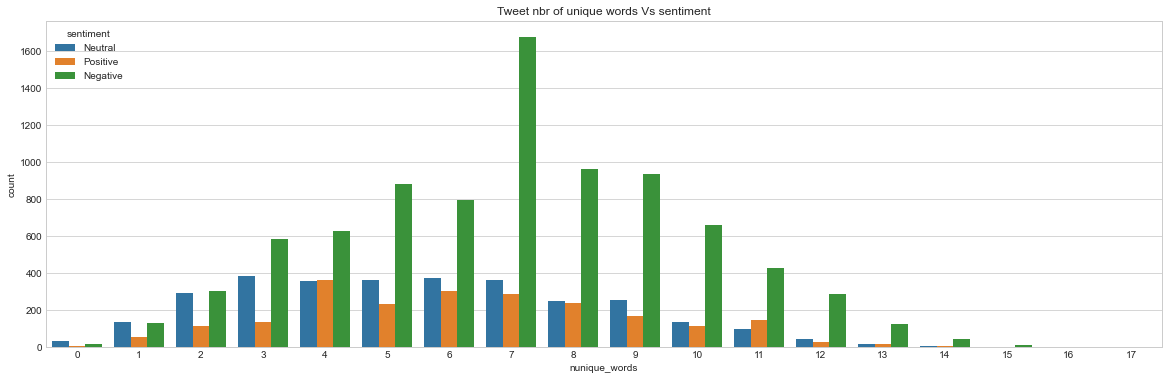

In [469]:
plt.figure(figsize=(20,6))
sns.countplot(tweets_complexity.nunique_words, hue=tweets_complexity.sentiment)
plt.title('Tweet nbr of unique words Vs sentiment')
plt.show()

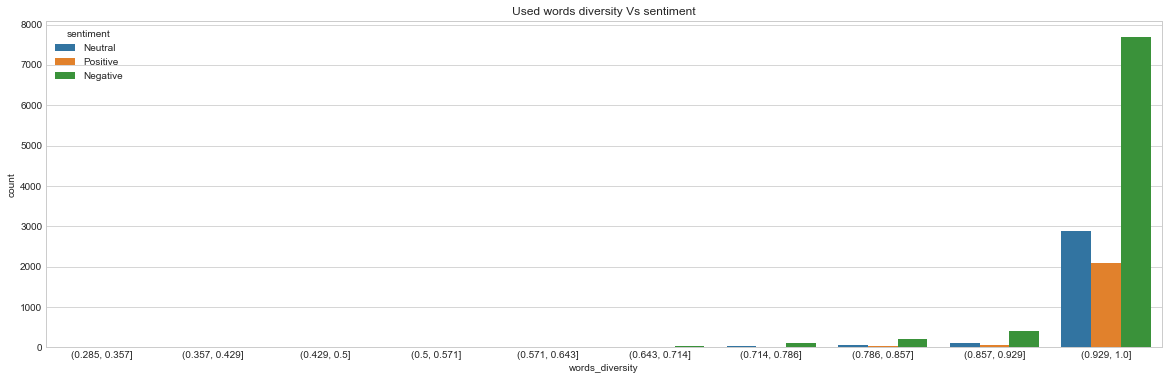

In [470]:
plt.figure(figsize=(20,6))
sns.countplot(pd.cut(tweets_complexity.words_diversity, 10), hue=tweets_complexity.sentiment)
plt.title('Used words diversity Vs sentiment')
plt.show()

## tweet_created

let's create four categories out of tweet_created.

- Noon: from 6:00 to 12:00 
- Afternoon: from 12:01 to 17:00
- Evening: from 17:01 to 20:00
- Night: from 20:01 to 5:59

In [505]:
def mapping_func(hour):
    if 6 < hour <= 12:
        return 'Noon'
    elif 12 < hour <= 17:
        return 'Afternoon'
    elif 17 < hour <= 20:
        return 'Evening' 
    else:
        return 'Night'
period_of_day = tweets.tweet_created.dt.hour.apply(mapping_func)
tweets['period_of_day'] = period_of_day

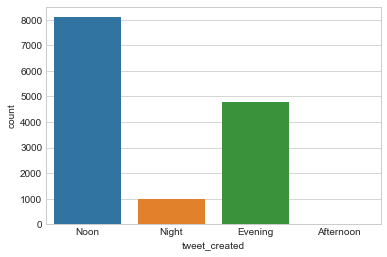

In [506]:
sns.countplot(period_of_day);

People tend to tweet more in the morning as well as in the evening before going to bed.

## Sentiment

Let's encode our classes into numerical values.

In [473]:
target_encoder = LabelEncoder()
y = pd.Series(target_encoder.fit_transform(tweets.sentiment))

As we saw in EDA ~30% of these two features is composed of missing values. Let's consider the missing value as another category therefore we will impute it -999.

Let's create two other feature, user_timezone_isna and tweet_location_isna which will hold a boolean value to indictate to the model the rows containing missing values respectively for user_timezone and tweet_location.

In [474]:
tweets['user_timezone_isna'] = tweets.user_timezone.isna().astype(int)
tweets['tweet_location_isna'] = tweets.tweet_location.isna().astype(int)
tweets['user_timezone'] = tweets.user_timezone.fillna(-999)
tweets['tweet_location'] = tweets.tweet_location.fillna(-999)

## Candidate

In [475]:
tweets.candidate.isna().sum()

96

When a candidate is not mentionned, the tweet is put in 'No candidate mentioned'. Therefore, I will consider the missing candidate values to be part of 'No candidate mentioned' category.

In [476]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')
tweets['candidate'] = imputer.fit_transform(tweets['candidate'].values.reshape(-1, 1))

## Data split

Our final dataset will be composed of the following features: user_timezone_isna, tweet_location_isna, user_timezone, tweet_location, text embeddings, retweet_count and candidate

In [507]:
boolean_features = ['user_timezone_isna', 'tweet_location_isna']
categorical_features = ['candidate', 'user_timezone', 'tweet_location', 'period_of_day']
numerical_features = ['retweet_count']
embeddings = ['text']

In [508]:
tweets[boolean_features+categorical_features+numerical_features+embeddings].sample(5)

,user_timezone_isna,tweet_location_isna,candidate,user_timezone,tweet_location,period_of_day,retweet_count,text
7628,0,0,No candidate mentioned,Central Time (US & Canada),NOLA,Noon,19,RT @warriorwoman91: Many Republicans are upset...
3028,0,0,Ben Carson,Tijuana,Northeast,Noon,2,Ben Carson at last night's #GOPDebate http://t...
10281,1,1,No candidate mentioned,-999,-999,Evening,1,"This isn't the republican primary, it's So You..."
8725,0,0,No candidate mentioned,Eastern Time (US & Canada),"Boston, MA",Night,116,RT @RWSurferGirl: So @megynkelly posed for adu...
10598,0,0,No candidate mentioned,Atlantic Time (Canada),wrong levvvveeeeerrrrr,Evening,0,sad to say that SNL hasnt written a comedy ske...


In [479]:
from sklearn.model_selection import train_test_split

SEED = 42

X_train, X_test, y_train, y_test = train_test_split(tweets[boolean_features+categorical_features+numerical_features+embeddings], y, test_size=.2,
                               stratify=y, random_state=SEED)

# Pipeline

For the categorical variable, I suggest that we count encode them. Basically we will replace each categorie by it's number of occurences.

In [500]:
class Doc2Vec(BaseEstimator):

    def __init__(self, vector_size=50, min_count=2, epochs=40):        
        self.vector_size=vector_size
        self.min_count=min_count
        self.epochs=epochs
        
    def __pre_process(self, X, train_tag=True):
        X_tr = X.copy()
        X_tr = X_tr.text.str.replace(r'[#@RT]+\S+', '')
        X_tr = X_tr.str.replace('&amp;', '')
        X_tr = X_tr.str.replace(r'http[s]*\S+', '')
        X_tr = X_tr.str.replace(r'\s+', ' ').str.strip()
        X_tr = X_tr.str.lower()

        X_tr = X_tr.apply(word_tokenize)

        X_tr = [[token.lower() for token in tokens if token.isalpha()] for tokens in X_tr]
        X_tr = [[token.lower() for token in tokens] for tokens in X_tr]
        # no lemmatization or stemming since we are going to use pre-trained embeddings


        # delete stop words
        X_tr = [[token.lower() for token in tokens if token not in stop_words] for tokens in X_tr]
        
        X_tag = []
        for i, doc in enumerate(X_tr):
                # For training data, add tags
                if train_tag:
                    X_tag.append(gensim.models.doc2vec.TaggedDocument(doc, [i]))
                else:
                    X_tag.append(doc)
        
        return list(X_tag)
    
    def fit(self, X_train, y=None):
        self.model = gensim.models.doc2vec.Doc2Vec(vector_size=self.vector_size, min_count=self.min_count, epochs=self.epochs)
        X_train_tag = self.__pre_process(X_train)
        self.model.build_vocab(X_train_tag) 
        self.model.train(X_train_tag, total_examples=self.model.corpus_count, epochs=self.model.epochs)
        
        return self

    def transform(self, X):
        X_tr = self.__pre_process(X, train_tag=False)
        doc2vec_embeddings = np.array([self.model.infer_vector(doc) for doc in X_tr])
        
        return doc2vec_embeddings

class CountEncoder(BaseEstimator):

    def __init__(self, normalize=True):
        self.normalize = normalize

    def fit(self, X_train, y=None):
        self.__set_mapping(X_train)
        
        return self

    def transform(self, X):
        X_tr = X.copy()

        if type(X) != type(pd.DataFrame()): 
            raise ValueError(f'{type(X)} not supported')
        
        col_id = 0
        for col, serie in  X.iteritems():
            X_tr[col] = serie.map(self.mapping_list[col_id])
            col_id += 1
        
        return X_tr

    def __set_mapping(self, X):
        if type(X) != type(pd.DataFrame()):
            raise ValueError(f'{type(X)} not supported')

        self.mapping_list = []
        for col, serie in X.iteritems():
            if self.normalize:
                self.mapping_list.append((serie.value_counts()/serie.value_counts().max()).to_dict())
            else:
                self.mapping_list.append(serie.value_counts().to_dict())

In [484]:
static_params = {
    'objective': 'multi:softmax',
    'boosting_type': 'gbdt',
    'num_class': 3,
    'max_depth': 5
}


feature_engineering = ColumnTransformer([('CountEncoder', CountEncoder(), categorical_features),
                                         ('doc2vec', Doc2Vec(), embeddings)],
                                         remainder='passthrough', verbose=0)

steps = [('feature_engineering', feature_engineering),
         ('model', XGBClassifier(**static_params))
        ]

model = Pipeline(steps)
    


model.fit(X_train, y_train)

[12:55:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { boosting_type } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




Pipeline(steps=[('feature_engineering',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('CountEncoder',
                                                  CountEncoder(),
                                                  ['candidate', 'user_timezone',
                                                   'tweet_location']),
                                                 ('doc2vec', Doc2Vec(),
                                                  ['text'])],
                                   verbose=0)),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               boosting_type='gbdt', colsample_bylevel=1,
                               colsample_bynode=1, colsample_bytree=...
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=5, min_child_weight=1

In [485]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.68      0.90      0.78      1699
           1       0.49      0.22      0.31       629
           2       0.57      0.32      0.41       447

    accuracy                           0.65      2775
   macro avg       0.58      0.48      0.50      2775
weighted avg       0.62      0.65      0.61      2775



In [486]:
print(classification_report(y_train, model.predict(X_train)))

              precision    recall  f1-score   support

           0       0.76      0.95      0.84      6794
           1       0.77      0.45      0.56      2513
           2       0.81      0.54      0.65      1789

    accuracy                           0.77     11096
   macro avg       0.78      0.64      0.69     11096
weighted avg       0.77      0.77      0.75     11096



The model performed badly, maybe this is caused by class imbalance. Let's use SMOTE to create synthetic embeddings.

## Create synthetic tweets by applying SMOTE

In [487]:
static_params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'max_depth': 5
}


feature_engineering = ColumnTransformer([('CountEncoder', CountEncoder(), categorical_features),
                                         ('doc2vec', Doc2Vec(), embeddings)],
                                         remainder='passthrough', verbose=0)
strategy = {0:6794, 1:6794, 2:6794}

X_train_tr = feature_engineering.fit_transform(X_train, y_train)
sm = SMOTE(sampling_strategy=strategy)
X_train_tr_res, y_train_res = sm.fit_resample(X_train_tr, y_train)

model = XGBClassifier(**static_params)

model.fit(X_train_tr_res, y_train_res)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [488]:
print(classification_report(y_test, model.predict(feature_engineering.transform(X_test))))

              precision    recall  f1-score   support

           0       0.70      0.79      0.74      1699
           1       0.42      0.32      0.36       629
           2       0.45      0.38      0.42       447

    accuracy                           0.62      2775
   macro avg       0.52      0.50      0.51      2775
weighted avg       0.60      0.62      0.60      2775



In [489]:
print(classification_report(y_train_res, model.predict(X_train_tr_res)))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      6794
           1       0.92      0.92      0.92      6794
           2       0.94      0.95      0.94      6794

    accuracy                           0.93     20382
   macro avg       0.93      0.93      0.93     20382
weighted avg       0.93      0.93      0.93     20382



- the model has over-fitted the data, and has not generalized well.

The model performs poorly, it could be that the the number of samples is not sufficient for the model to perform better. 

Options to consider in order to improve the model performance:

- perform a grid search to optimize hyper-parameters
- feature engineering

# RNN with pre-trained embeddings

In [374]:
def pre_process_data(df):
    df_cleaned = df.copy()
    df_cleaned['text_cleaned'] = df.text.str.replace('[#@RT]+\S+', '')
    df_cleaned['text_cleaned'] = df_cleaned.text_cleaned.str.replace('&amp;', '')
    df_cleaned['text_cleaned'] = df_cleaned.text_cleaned.str.replace(r'http[s]*\S+', '')
    df_cleaned['text_cleaned'] = df_cleaned.text_cleaned.str.replace('\s+', ' ').str.strip()
    df_cleaned['text_cleaned'] = df_cleaned.text_cleaned.str.lower()
    df_cleaned['tokens'] = df_cleaned.text_cleaned.apply(word_tokenize)
    df_cleaned['tokens'] = df_cleaned.tokens.apply(lambda tokens: [token for token in tokens if token.isalpha()])
    df_cleaned['tokens'] = df_cleaned.tokens.apply(lambda tokens: [token for token in tokens if token not in stop_words])

    return df_cleaned

def get_vector(word, embeddings):
    return embeddings.loc[word].to_list()

In [375]:
import csv
words = pd.read_table('glove.6B.50d.txt', sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)
glove_vocab = words.index.to_list()

In [514]:
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler

X = tweets[boolean_features+categorical_features+numerical_features+embeddings]

# encode target variable
target_encoder = LabelEncoder()
y = pd.Series(target_encoder.fit_transform(tweets.sentiment))

# encode categories
y_encoded = to_categorical(y, num_classes=3)

# clean 
print('cleaning tweets...')
X = pre_process_data(X)

# data split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y_encoded,
                                                    stratify=y)

feature_engineering = ColumnTransformer([('CountEncoder', CountEncoder(), categorical_features),
                                         ('scaler', StandardScaler(), numerical_features)],
                                         remainder='drop', verbose=0)

X_train_other_features = feature_engineering.fit_transform(X_train)
X_test_other_features = feature_engineering.transform(X_test)

# get vocab from train set
vocab_twitter = []
for index, tokens in X_train.tokens.iteritems():
    vocab_twitter.extend(list(set(tokens)))

vocab_twitter = list(set(vocab_twitter))
print(f'There is {len(vocab_twitter)} unique word in tweets corpus')

covered_vocab_count = 0
for vocab in vocab_twitter:
    if vocab in glove_vocab:
        covered_vocab_count += 1
        
print(f"{covered_vocab_count/len(vocab_twitter):.2%} of the the vocab is covered by Glove")

word_to_index = {v:k for k, v in enumerate(vocab_twitter, start=1)}
index_to_word = {k:v for k, v in enumerate(vocab_twitter, start=1)}

# this will be used as default value for words that do not belong to vocab extracted from train set
word_to_index['<UNKW>'] = 0
index_to_word[0] = '<UNKW>'

index_to_word = {k:v for k, v in sorted(index_to_word.items(), key=lambda x: x[0])}
word_to_index = {k:v for k, v in sorted(word_to_index.items(), key=lambda x: x[1])}

# on rajoute +1 car l'index 0 le RNN le reserve pour le padding
embedding_matrix = np.zeros((len(word_to_index)+1, 50))
for word, i in word_to_index.items():
    if word in glove_vocab:
        embedding_matrix[i] = get_vector(word, words)
    print(f"Progress {i/len(word_to_index):.2%}...", end='\r')
    
# convert word to index
X_train_idx = X_train.tokens.apply(lambda tokens: [word_to_index[token] for token in tokens])
X_train_pad = pad_sequences(X_train_idx, maxlen=13)

X_test_idx = tweets_cleaned_test.tokens.apply(lambda tokens: [word_to_index.get(token, 0) for token in tokens])
X_test_pad = pad_sequences(X_test_idx, maxlen=13)

cleaning tweets...
There is 8294 unique word in tweets corpus
94.90% of the the vocab is covered by Glove


In [517]:
X_train_other_features.shape, X_train_pad.shape

((10403, 5), (10403, 13))

In [557]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, LSTM, Dropout, Concatenate
from tensorflow.keras.initializers import Constant
from tensorflow.keras.regularizers import Regularizer, l1_l2

input_text_sequence = Input((13,))
input_other_features = Input((5,))

#RNN
embedding_output = Embedding(input_dim=len(word_to_index) + 1, output_dim=50, 
                    embeddings_initializer=Constant(embedding_matrix), 
                    input_length=13, trainable=False)(input_text_sequence)

seq2seq_output = GRU(128, return_sequences=True)(embedding_output)
drop_out = Dropout(0.2)(seq2seq_output)
seq2out_output = GRU(128, return_sequences=False)(drop_out)
mdl_a = Model(inputs=input_text_sequence, outputs=seq2out_output)

#MLP
y = Dense(50, activation='relu', kernel_regularizer=l1_l2(0.02))(input_other_features)
y = Dense(50, activation='relu', kernel_regularizer=l1_l2(0.02))(y)
mdl_b = Model(inputs=input_other_features, outputs=y)

# stacking 
combined = Concatenate()([mdl_a.output, mdl_b.output])
z = Dense(10, activation="relu")(combined)
model_proba = Dense(3, activation='softmax')(z)

model = Model(inputs=[mdl_a.input, mdl_b.input], outputs=model_proba)

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "functional_100"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_44 (InputLayer)           [(None, 13)]         0                                            
__________________________________________________________________________________________________
embedding_58 (Embedding)        (None, 13, 50)       414800      input_44[0][0]                   
__________________________________________________________________________________________________
gru_80 (GRU)                    (None, 13, 128)      69120       embedding_58[0][0]               
__________________________________________________________________________________________________
input_45 (InputLayer)           [(None, 5)]          0                                            
_____________________________________________________________________________________

In [558]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
callbacks = [EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)]
model.fit(x=[X_train_pad, X_train_other_features], y=y_train, validation_split=0.2,
          batch_size=64, epochs=40, callbacks=callbacks, class_weight={0:1, 1: 3, 2:4})

Epoch 1/40
131/131 [==============================] - 9s 68ms/step - loss: 6.3129 - accuracy: 0.4847 - val_loss: 2.8109 - val_accuracy: 0.5247
Epoch 2/40
131/131 [==============================] - 7s 56ms/step - loss: 2.5538 - accuracy: 0.5441 - val_loss: 0.9709 - val_accuracy: 0.5968
Epoch 3/40
131/131 [==============================] - 8s 57ms/step - loss: 1.8311 - accuracy: 0.5716 - val_loss: 0.9659 - val_accuracy: 0.5382
Epoch 4/40
131/131 [==============================] - 7s 57ms/step - loss: 1.7638 - accuracy: 0.5741 - val_loss: 0.9108 - val_accuracy: 0.5781
Epoch 5/40
131/131 [==============================] - 7s 56ms/step - loss: 1.6898 - accuracy: 0.5987 - val_loss: 0.9378 - val_accuracy: 0.5656
Epoch 6/40
131/131 [==============================] - 7s 56ms/step - loss: 1.6336 - accuracy: 0.6145 - val_loss: 0.8671 - val_accuracy: 0.5944
Epoch 7/40
131/131 [==============================] - 8s 57ms/step - loss: 1.5695 - accuracy: 0.6342 - val_loss: 0.9174 - val_accuracy: 0.5718

In [559]:
y_pred_proba = model.predict([X_test_pad, X_test_other_features])
y_pred_label = [np.argmax(y) for y in y_pred_proba]
y_pred_true = [np.argmax(y) for y in y_test]

In [562]:
from sklearn.metrics import classification_report
print(classification_report(y_pred_label, y_pred_true))

              precision    recall  f1-score   support

           0       0.68      0.60      0.64      2409
           1       0.17      0.22      0.19       631
           2       0.13      0.18      0.15       428

    accuracy                           0.48      3468
   macro avg       0.33      0.33      0.33      3468
weighted avg       0.52      0.48      0.50      3468

